# 1. PREPRARACION DEL DATASET

 1.1 Carga de datos y exploraciones previas al EDA

 1.2. Preparación y limpieza de Datos

 1.2.1 Transformación de Datos

 1.2.2 Filtración de duplicados

 1.2.3 Verificación de unicidad en los valores del dataset 
 
 1.2.4 Selección y Depuración de Variables No Relevantes

 1.3 Creación de embeddings

 1.4 Creación del dataset con embeddings


 



In [1]:
import pandas as pd
import glob
import os
import numpy  as np
import os
import time    
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from umap import UMAP
import hdbscan
from sklearn.preprocessing import StandardScaler  # (opcional)
import matplotlib.pyplot as plt

## 1.1 Carga de datos y exploraciones previas al EDA

In [2]:
ruta_low  = "/Users/danielmunoz/Documents/EDUCACION/DATA_ANALIST/CURSOS/TFM/DATA/RAW/DATASET/NOPOPULAR_2"
ruta_mpop = "/Users/danielmunoz/Documents/EDUCACION/DATA_ANALIST/CURSOS/TFM/DATA/RAW/DATASET/MOST_POPULAR_3"

archivos_low  = glob.glob(os.path.join(ruta_low,  "*.csv"))
archivos_mpop = glob.glob(os.path.join(ruta_mpop, "*.csv"))

print(f"Archivos NOPOPULAR: {len(archivos_low)}")
print(f"Archivos MOSTPOPULAR: {len(archivos_mpop)}")

def leer_flexible(path, label):
    # 1) intenta con ';'
    try:
        df = pd.read_csv(
            path,
            sep=";",
            engine="python",
            encoding="utf-8",
            on_bad_lines="skip"
        )
    except Exception:
        # 2) intenta con ','
        df = pd.read_csv(
            path,
            sep=",",
            engine="python",
            encoding="utf-8",
            on_bad_lines="skip"
        )

    # Si quedó todo en una sola columna (delimitador incorrecto), intenta sniff automático
    if df.shape[1] == 1:
        df = pd.read_csv(
            path,
            sep=None,              # sniff del separador
            engine="python",
            encoding="utf-8",
            on_bad_lines="skip"
        )

    df = df.assign(mostpopular=label, source_file=os.path.basename(path))
    return df

def concat_seguro(lista_paths, label):
    if not lista_paths:
        # Devuelve DataFrame vacío con la columna mostpopular para no romper concat
        return pd.DataFrame(columns=["mostpopular", "source_file"])
    frames = []
    for f in lista_paths:
        try:
            frames.append(leer_flexible(f, label))
        except Exception as e:
            print(f"[WARN] No se pudo leer {f}: {e}")
    if frames:
        return pd.concat(frames, ignore_index=True)
    # Si ninguno se pudo leer, devolver DF vacío coherente
    return pd.DataFrame(columns=["mostpopular", "source_file"])

df_low  = concat_seguro(archivos_low,  label=0)
df_mpop = concat_seguro(archivos_mpop, label=1)

# Unificar
df = pd.concat([df_low, df_mpop], ignore_index=True)

print(df.shape)
print(df.head())

Archivos NOPOPULAR: 60
Archivos MOSTPOPULAR: 60
(29398, 34)
      video_id                                              title  \
0  VNqRXbyw6x0        ¿Cómo CURAR una GASTRITIS? | DrPoloGuerrero   
1  3r3GAwGndCI  Lamine Yamal vs Como 1907 | 2 Goals (10/08/202...   
2  a6mN0flleb8  Cómo Chile reinventó el Leopard 1v y así lo hi...   
3  q9t5tF14vgI  COMO se HACE el CONTRACHAPADO de MADERA |ASÍ s...   
4  Oy7U8VGmdzQ  ¡SHOCK AÉREO GLOBAL! : ¿Cómo Rusia derriba un ...   

                                         description          published_at  \
0  ANTES DE TRATAR UNA GASTRITIS, NECESITAMOS SAB...  2025-08-11T01:30:22Z   
1  Lamine Yamal vs Como 1907 (10/08/2025)\n\n🔔 Tu...  2025-08-10T22:55:33Z   
2  Cómo Chile reinventó el Leopard 1 y lo convirt...  2025-08-10T22:00:03Z   
3  🔰Descubre COMO se HACE el CONTRACHAPADO de MAD...  2025-08-10T16:45:04Z   
4  En este video abordamos la alarmante situación...  2025-08-10T14:08:00Z   

  duration_minutes definition licensed_content has_capti

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29398 entries, 0 to 29397
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                29397 non-null  object 
 1   title                   29398 non-null  object 
 2   description             25433 non-null  object 
 3   published_at            29397 non-null  object 
 4   duration_minutes        29397 non-null  object 
 5   definition              29397 non-null  object 
 6   licensed_content        29397 non-null  object 
 7   has_caption             29396 non-null  object 
 8   category_id             29396 non-null  float64
 9   views                   29396 non-null  float64
 10  likes                   29396 non-null  float64
 11  comments                29395 non-null  float64
 12  tags                    19244 non-null  object 
 13  tags_count              29396 non-null  float64
 14  views_per_day           29396 non-null

Primeras exploraciones y preaparacion inicial del dataset

In [4]:

count_3d = df[(df["mostpopular"] == 1) & (df["video_age_days"] == 3)].shape[0]
print("Número de vídeos trending al día 3:", count_3d)

Número de vídeos trending al día 3: 830


Sobre la selección de los vídeos en el 3er día

In [5]:
# Definir función para asignar franja
def asignar_franja(dias):
    if dias < 1:
        return "0-24h"
    elif dias < 2:
        return "24-48h"
    elif dias < 3:
        return "48-72h"
    elif dias < 4:
        return "72-96h"
    else:
        return "96h+"

# Crear columna de franja
df["franja_trending"] = df["video_age_days"].apply(asignar_franja)

# Filtrar solo vídeos mostpopular
df_mp = df[df["mostpopular"] == 1]

# Contar y calcular porcentajes
dist = df_mp["franja_trending"].value_counts(normalize=True).sort_index() * 100

print("Distribución de entrada a trending por franja (en %):")

Distribución de entrada a trending por franja (en %):


In [6]:
dist

franja_trending
0-24h     37.934363
24-48h    28.281853
48-72h    11.600562
72-96h     7.283257
96h+      14.899965
Name: proportion, dtype: float64

In [7]:
tabla = pd.crosstab(df["franja_trending"], df["mostpopular"], normalize="columns") * 100
print(tabla)

mostpopular              0          1
franja_trending                      
0-24h             0.005555  37.934363
24-48h            0.000000  28.281853
48-72h            0.000000  11.600562
72-96h           99.983335   7.283257
96h+              0.011110  14.899965


La selección de la ventana de tres días como criterio de análisis se justifica en términos metodológicos. En primer lugar, se observa que los vídeos no incluidos en la sección *most popular* se concentran casi en su totalidad en la franja 72–96 horas tras su publicación. Por otra parte, los vídeos que sí alcanzan la categoría de *most popular* se distribuyen de forma más amplia a lo largo de las primeras 96 horas, pero mantienen una fracción representativa en la franja de tres días (≈8,7%). Este punto de intersección asegura la presencia de ambos grupos (trending y no trending) bajo una misma condición temporal, reduciendo sesgos asociados a la edad del vídeo. En consecuencia, el día tres constituye un horizonte razonable para evaluar el potencial de un vídeo de convertirse en trending, al equilibrar representatividad y homogeneidad en la muestra.

La construcción del dataset se realizó a partir de dos estrategias complementarias de muestreo. Por un lado, se recopilaron de forma diaria, durante un periodo de tres meses, los vídeos incluidos en la sección *most popular* de YouTube España. Por otro lado, se capturaron de manera paralela, a lo largo de dos meses, muestras diarias de vídeos publicados en los últimos tres días con menos de 50.000 visualizaciones. Con el fin de asegurar la coherencia metodológica, se seleccionaron únicamente los vídeos correspondientes al tercer día de publicación dentro de este segundo conjunto. Esta decisión responde al interés de generar una imagen representativa de la dinámica de consumo audiovisual en un momento específico, evitando el sesgo de comparar vídeos en fases temporales distintas de su ciclo de vida. De este modo, el dataset resultante permite contrastar de manera homogénea el comportamiento de vídeos trending frente a no trending bajo condiciones comparables.

In [8]:
df["franja_trending"].value_counts(normalize=True).sort_index() * 100

franja_trending
0-24h     14.708484
24-48h    10.963331
48-72h     4.496905
72-96h    64.048575
96h+       5.782706
Name: proportion, dtype: float64

In [9]:
df_1 = df[df["video_age_days"] == 3]

In [10]:
df_1['mostpopular'].value_counts(True)*100

mostpopular
0    95.591906
1     4.408094
Name: proportion, dtype: float64

/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_1989/1564616768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['published_at'] = pd.to_datetime(df_1['published_at'])
/var/folders/l5/hswxnhp96655ttqlpbgkrrfw0000gn/T/ipykernel_1989/1564616768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['published_date'] = df_1['published_at'].dt.date


<Figure size 1200x1000 with 0 Axes>

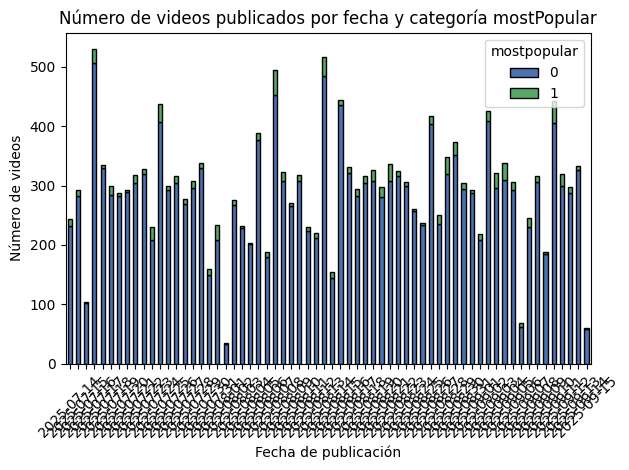

In [11]:
df_1['published_at'] = pd.to_datetime(df_1['published_at'])

# Crear una columna de fecha solo (sin hora) para agrupar
df_1['published_date'] = df_1['published_at'].dt.date
tabla_frecuencia = df_1.groupby(['published_date', 'mostpopular']).size().unstack(fill_value=0)

# Graficar barras apiladas
plt.figure(figsize=(12,10))
tabla_frecuencia.plot(kind='bar', stacked=True, color=['#4C72B0','#55A868'], edgecolor='black')
plt.title('Número de videos publicados por fecha y categoría mostPopular')
plt.xlabel('Fecha de publicación')
plt.ylabel('Número de videos')
plt.xticks(rotation=45)
plt.tight_layout()

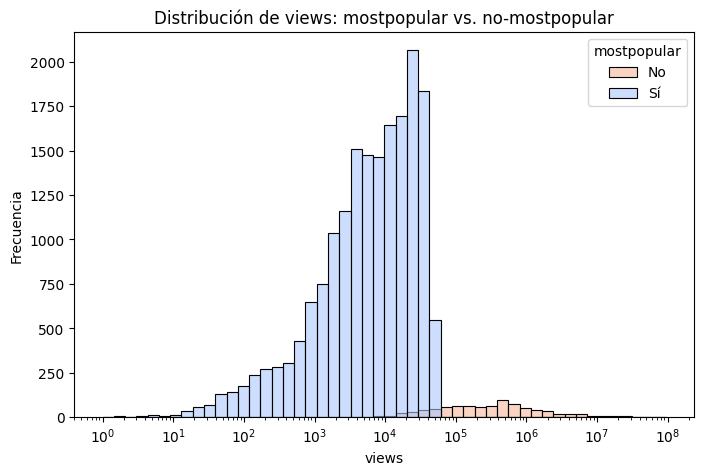

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_1, x=df_1['views'], hue="mostpopular", bins=50, log_scale=True, 
                 palette="coolwarm", alpha=0.6)
plt.title(f"Distribución de views: mostpopular vs. no-mostpopular")
plt.xlabel("views")
plt.ylabel("Frecuencia")
plt.legend(title="mostpopular", labels=["No", "Sí"])
plt.show()

## 1.2. Preparación y limpieza de Datos

In [13]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18829 entries, 0 to 29320
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                18829 non-null  object             
 1   title                   18829 non-null  object             
 2   description             15125 non-null  object             
 3   published_at            18829 non-null  datetime64[ns, UTC]
 4   duration_minutes        18829 non-null  object             
 5   definition              18829 non-null  object             
 6   licensed_content        18829 non-null  object             
 7   has_caption             18829 non-null  object             
 8   category_id             18829 non-null  float64            
 9   views                   18829 non-null  float64            
 10  likes                   18829 non-null  float64            
 11  comments                18829 non-null  float6

In [14]:
#Hay un valor en todos los datos raw de channel, que no fueron bien capturados. Eliminándo con `dropna` los valores existentes en la fila "channel_creates"
# eliminamos estos valores faltantes
df_1 = df_1.dropna(subset=["channel_created"])

In [15]:
# Los valores faltantes (7) en engagement_rate, efficiency, engagement_subscribers; y 18822 en favorites, likes_per_view y comments_per_view 
# se debe al gap en el uso de diferente código en los batch de captura de vídeos para los subsets "mostpopular" y "vídeos <50000 views"
# Para resolver esta situacion eliminamos las columnas para volver a reconstruirlas posteriormente para todo el dataset en su totalidad 
df_1 = df_1.drop(
    columns=["franja_trending","channel_title_canonical","comments_per_view","likes_per_view", "favorites","source_file",
             "views_rate_video","engagement_subscribers","frecuencia_videos","engagement_rate",
             "efficiency"],
    errors="ignore"
)

In [16]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18828 entries, 0 to 29320
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   video_id             18828 non-null  object             
 1   title                18828 non-null  object             
 2   description          15124 non-null  object             
 3   published_at         18828 non-null  datetime64[ns, UTC]
 4   duration_minutes     18828 non-null  object             
 5   definition           18828 non-null  object             
 6   licensed_content     18828 non-null  object             
 7   has_caption          18828 non-null  object             
 8   category_id          18828 non-null  float64            
 9   views                18828 non-null  float64            
 10  likes                18828 non-null  float64            
 11  comments             18828 non-null  float64            
 12  tags                 10

### 1.2.1 Transformación de Datos

- **Variables numéricas:** Se aplican transformaciones a variables `int64` para manejar valores extremos y mejorar la comparabilidad entre columnas.  

- **Variables categóricas:** La columna `category_id` se convierte a tipo `category` para optimizar memoria, facilitar el análisis exploratorio y preparar la codificación para modelos de Machine Learning.  

- **Variables binarias:** Columnas como `definition`, `has_caption` y `licensed_content` se transforman a `int64` dada su naturaleza booleana (0/1). Esto permite trabajar de manera más eficiente en el EDA y facilita su tratamiento en modelos de ML.

In [17]:
cols_int = ["channel_views", "subscriber_count","channel_age_days","channel_video_count", "video_age_days", "views_per_day","tags_count","comments", "likes","views" ]  # las columnas que quieres
df_1[cols_int] = df_1[cols_int].astype("int64")
df_1["duration_minutes"] = pd.to_numeric(df_1["duration_minutes"], errors="coerce").astype(int)

In [18]:
df_1['category_id']=df_1['category_id'].astype('category')
df_1["licensed_content"] = (df_1["licensed_content"].astype(str).str.strip().str.lower().map({"true": 1, "false": 0}).astype("Int64"))          # Dado que me da problemas hago una limpieza simpleenteros con NA si algo no encaja
df_1["definition"] = df_1["definition"].map({"sd": 0, "hd": 1}).astype(int)
df_1["has_caption"] = (df_1["has_caption"].astype(str).str.strip().str.lower().map({"true": 1, "false": 0}).astype("Int64"))  

In [19]:
df_1=df_1.copy()

In [20]:
#Reconstruirmos las variables derivadas

def division_segura(numerador, denominador):
    return np.where(denominador > 0, numerador / denominador, 0)

df_1["engagement_rate"] = division_segura(
    df_1["likes"] + df_1["comments"], 
    df_1["views"]
)

df_1["efficiency"] = division_segura(
    df_1["likes"] + df_1["comments"], 
    df_1["channel_video_count"]
)

df_1["engagement_subscribers"] = division_segura(
    df_1["likes"] + df_1["comments"], 
    df_1["subscriber_count"]
)

df_1["frecuencia_videos"] = division_segura(
    df_1["channel_video_count"], 
    df_1["channel_age_days"]
)

df_1["views_rate_video"] = division_segura(
    df_1["channel_views"], 
    df_1["channel_video_count"]
)

df_1["likes_per_view"] = division_segura(
    df_1["likes"], 
    df_1["views"]
)

df_1["comments_per_view"] = division_segura(
    df_1["comments"], 
    df_1["views"]
)

### 1.2.2 Filtración de duplicados

- Empleamos `keep=False` con el objetivo de obtener el último valor registrado en nuestro dataset, dado que muchos de los vídeos **most popular** aparecen en la lista durante varios días.  
- Con el objetivo de capturar aquellos valores que reflejan **mejor performance**, decidimos filtrar los datos siguiendo la lógica mencionada anteriormente.

In [21]:
duplicados = df_1[df_1["video_id"].duplicated(keep=False)].sort_values("published_at")
df_sin_repeticion = df_1.drop_duplicates(subset="video_id", keep="last")

In [22]:
#Reseteamos el índice
df_1 = df_1.reset_index(drop=True)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18828 entries, 0 to 18827
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                18828 non-null  object             
 1   title                   18828 non-null  object             
 2   description             15124 non-null  object             
 3   published_at            18828 non-null  datetime64[ns, UTC]
 4   duration_minutes        18828 non-null  int64              
 5   definition              18828 non-null  int64              
 6   licensed_content        18828 non-null  Int64              
 7   has_caption             18828 non-null  Int64              
 8   category_id             18828 non-null  category           
 9   views                   18828 non-null  int64              
 10  likes                   18828 non-null  int64              
 11  comments                18828 non-null  i

In [23]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18828 entries, 0 to 18827
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                18828 non-null  object             
 1   title                   18828 non-null  object             
 2   description             15124 non-null  object             
 3   published_at            18828 non-null  datetime64[ns, UTC]
 4   duration_minutes        18828 non-null  int64              
 5   definition              18828 non-null  int64              
 6   licensed_content        18828 non-null  Int64              
 7   has_caption             18828 non-null  Int64              
 8   category_id             18828 non-null  category           
 9   views                   18828 non-null  int64              
 10  likes                   18828 non-null  int64              
 11  comments                18828 non-null  i

### 1.2.3 Verificación de unicidad en los valores del dataset

In [24]:
df_1["video_id"] = df_1["video_id"].astype(str).str.strip()

print("Filas totales:", len(df_1))
print("Video_id únicos:", df_1["video_id"].nunique())
print("¿Todos únicos?:", df_1["video_id"].nunique() == len(df_1))

Filas totales: 18828
Video_id únicos: 17825
¿Todos únicos?: False


### 1.2.4 Selección y Depuración de Variables No Relevantes

- Se eliminaron las columnas `"franja_trending"`, `"channel_title_canonical"` y `"source_file"` ya que son variables utilizadas únicamente para verificación de la funcionalidad del dataset.  
- La columna `"favorites"` se depuró porque es una categoría vacía; el API de YouTube no genera información al respecto.  
- Las columnas relacionadas con fechas (`"published_date"`, `"channel_created"`, `"published_at"`) también fueron filtradas:  
  - `"published_at"`, que indica cuándo se publicó el vídeo, se eliminó porque el objetivo de esta investigación es analizar la performance de los vídeos desde una lógica **sincrónica**, es decir, una fotografía fija en el tiempo, por lo que esta información pierde relevancia.  
  - `"channel_created"` se transformó en la diferencia en días desde la creación del canal hasta la publicación y captura del vídeo.  
  - `"published_date"` corresponde a una transformación interna realizada para la verificación del dataset.  

In [25]:
df_1 = df_1.drop(columns=["franja_trending","channel_title_canonical","favorites","source_file",
                          "published_at","channel_created","published_at"],
    errors="ignore")

## 1.3 Creación de embeddings

- EXPLICACION DEL PROCESO COMO TAL

In [26]:
# ========= 0) Imports y utilidades =========

def l2_normalize(X, eps=1e-12):
    X = np.asarray(X)
    if X.ndim == 1:
        n = np.linalg.norm(X)
        return X / (n + eps)
    n = np.linalg.norm(X, axis=1, keepdims=True)
    return X / (n + eps)

# Convierte una Serie de arrays en matriz 2D (útil luego para PCA/Modelos)
def stack_array_col(X):
    return np.vstack(X.iloc[:, 0].to_numpy())


# ========= 1) Textos (limpieza ligera y etiquetas) =========
# asumimos que tu DF se llama df_video y tiene estas columnas
# ["video_id","channel_id","title","description","tags","channel_title","channel_description"]

df_1["text_video"] = (
    "[TITLE] " + df_1["title"].fillna("") + " "
    "[DESC] "  + df_1["description"].fillna("") + " "
    "[TAGS] "  + df_1["tags"].fillna("")
).str.replace(r"\s+", " ", regex=True).str.strip()

# texto de canal: calcular UNA vez por canal
ch_base = (df_1[["channel_id","channel_title","channel_description"]]
           .drop_duplicates("channel_id")
           .copy())
ch_base["text_channel"] = (
    "[CHANNEL] " + ch_base["channel_title"].fillna("") + " "
    "[DESC] "    + ch_base["channel_description"].fillna("")
).str.replace(r"\s+", " ", regex=True).str.strip()


# ========= 2) Cargar modelo multilingüe =========
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"  # 384 dims
model = SentenceTransformer(model_name)


# ========= 3) Embeddings (vídeo y canal-raw) =========
# Vídeo
v_emb = model.encode(
    df_1["text_video"].tolist(),
    batch_size=64, convert_to_numpy=True, show_progress_bar=True
)
v_emb = l2_normalize(v_emb)

# Canal (texto propio del canal, mapeado a cada channel_id)
c_raw = model.encode(
    ch_base["text_channel"].tolist(),
    batch_size=64, convert_to_numpy=True, show_progress_bar=True
)
c_raw = l2_normalize(c_raw)
c_raw_map = dict(zip(ch_base["channel_id"].tolist(), list(c_raw)))


# ========= 4) Embedding de canal agregado (media simple de sus vídeos) =========
# (sin ponderar: tu dataset es ~3 días de antigüedad)
means = {}
tmp = pd.DataFrame({"channel_id": df_1["channel_id"].values,
                    "row_idx": np.arange(len(df_1))})
for ch_id, idxs in tmp.groupby("channel_id")["row_idx"]:
    m = v_emb[idxs.to_numpy()].mean(axis=0)
    means[ch_id] = l2_normalize(m)

# Mezcla canal final = 50% texto canal + 50% media de vídeos
beta = 0.5
c_final_map = {ch: l2_normalize(beta * c_raw_map[ch] + (1 - beta) * means[ch])
               for ch in means.keys()}


# ========= 5) Embedding conjunto por vídeo (vídeo + canal_final) =========
alpha = 0.7  # 70% vídeo, 30% contexto de canal
c_final_mat = np.vstack(df_1["channel_id"].map(c_final_map).to_numpy())
joint_emb = l2_normalize(alpha * v_emb + (1 - alpha) * c_final_mat)

# Guardar en el DataFrame (como arrays por fila) para no recomputar
df_1["embedding_video"]         = list(v_emb)
df_1["embedding_channel_raw"]   = df_1["channel_id"].map(c_raw_map)
df_1["embedding_channel_agg"]   = df_1["channel_id"].map(means)
df_1["embedding_channel_final"] = df_1["channel_id"].map(c_final_map)
df_1["embedding_joint"]         = list(joint_emb)

# (opcional) persistir
df_1.to_parquet("/Users/danielmunoz/Documents/EDUCACION/DATA_ANALIST/CURSOS/TFM/DATA/PROCESSED/df_TFMYouTube_embeddings_DEFINITIVO.parquet", index=False)

Batches:   0%|          | 0/295 [00:00<?, ?it/s]

Batches:   0%|          | 0/164 [00:00<?, ?it/s]

# 1.4 Creación del dataset con embeddings

In [28]:
# df_1.to_parquet(
#       "/Users/danielmunoz/Documents/EDUCACION/DATA_ANALIST/CURSOS/TFM/DATA/PROCESSED/df_YouTube_2025TFM_DEFINITIVO.parquet",
#      index=False)